<a href="https://www.kaggle.com/code/ahmedmostafa2000/parkinson-s2l?scriptVersionId=134277225" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from IPython.display import clear_output
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
clear_output()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import gc, os, glob, random
from os import path
from pathlib import Path
# make data
import polars as pl
import pandas as pd
pd.set_option('display.max_columns', None); # pd.set_option('display.max_rows', None)
import numpy as np
from tqdm.auto import tqdm
import ydata_profiling as pdp

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
tdcsfog_path = glob.glob("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/*.csv")
tdcsfog_metadata=pd.read_csv('../input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
df_tdcsfog = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/003f117e14.csv")

# =====================================
# load data & concat
# =====================================
df_list = []
for idx, path in tqdm(enumerate(tdcsfog_path)):
    df = pl.read_csv(path)
    filename = os.path.basename(path).split(".cs")[0]
    tmp = pl.DataFrame(
        {
            "idx": [idx]*len(df),
            "ID": [filename]*len(df),
            "len_df": len(df),
        }
    )
    df = pl.concat([df, tmp], how="horizontal")
    df_list.append(df)
    
df_tdcsfog = pl.concat(df_list)

0it [00:00, ?it/s]

In [18]:
df = pd.DataFrame(df_tdcsfog, columns = df_tdcsfog.columns)
df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)

In [19]:
df[['fog','normal']] = pd.get_dummies(df['class'], prefix='class')

In [22]:
import tensorflow as tf

def normalize_data(dataset):
    # Compute the mean and standard deviation of the dataset
    mean = tf.reduce_mean(dataset, axis=0)
    std = tf.math.reduce_std(dataset, axis=0)
    
    # Normalize the dataset
    normalized_dataset = (dataset - mean) / std
    
    return normalized_dataset
df[['AccV','AccML','AccAP']] = normalize_data(np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float32))

<Axes: >

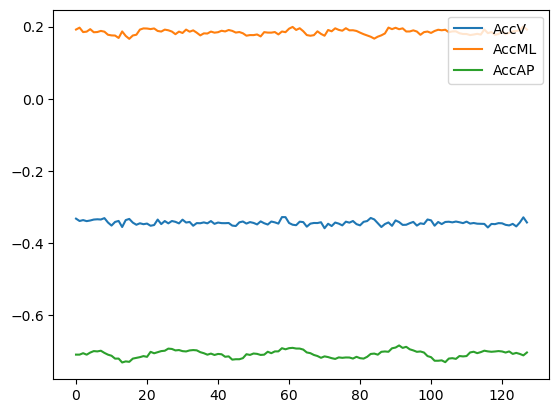

In [23]:
import matplotlib.pyplot as plt

df[['AccV','AccML','AccAP']][0:128].plot()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7062672 entries, 0 to 7062671
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             object 
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  object 
 5   Turn             object 
 6   Walking          object 
 7   idx              object 
 8   ID               object 
 9   len_df           object 
 10  class            int64  
 11  fog              uint8  
 12  normal           uint8  
dtypes: float64(3), int64(1), object(7), uint8(2)
memory usage: 606.2+ MB


In [24]:
x_win = []
y_win = []

x = df[['AccV','AccML','AccAP']]
y = df[['fog','normal']]

for i in range(0,len(df)-len(df)%256,128):
    x_win.append(x[i:i+256])
    y_win.append(y[i:i+256])
    
x_win.pop()
y_win.pop()
x_win = np.asarray(x_win,dtype = np.float32)
y_win = np.asarray(y_win,dtype = int)

In [25]:
from scipy import stats
y_win_s2l = []
for i in y_win:
    y_win_s2l.append(stats.mode(i)[0][0])
y_win_s2l = np.asarray(y_win_s2l,dtype = int)

/tmp/ipykernel_28/3589556084.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_win_s2l.append(stats.mode(i)[0][0])


In [60]:
y_win_s2l.shape

(55175, 2)

In [62]:
sum(y_win_s2l[:, 1])/len(y_win_s2l) , sum(y_win_s2l[:, 1])*55175/len(y_win_s2l) , 55175

(0.309941096511101, 17101.0, 55175)

In [26]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [81]:
# Callbacks
from keras.utils import tf_utils
class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",factor=0.5,patience=10,)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
checkpointer = ModelCheckpoint_tweaked(filepath='best.hdf5', verbose=0, save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger("model_history_log.csv", append=True)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_win, y_win_s2l, test_size=0.30, shuffle = False)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, shuffle = False)
# model = tf.keras.models.load_model('./best.hdf5')
model = Sequential([
    LSTM(100, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = True ),
    Dropout(0.2),
    LSTM(100, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)),
    Dropout(0.2),
    Dense(2, activation = 'softmax') 
])

model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, clipvalue=0.5),
                loss='categorical_crossentropy', 
                metrics=['accuracy'],
                )

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256, 100)          41600     
                                                                 
 dropout_8 (Dropout)         (None, 256, 100)          0         
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
Total params: 122,202
Trainable params: 122,202
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.fit(x_train, y_train, batch_size = 256, epochs = 200, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

Epoch 1/200
198/198 [==============================] - 248s 1s/step - loss: 0.7444 - accuracy: 0.6146 - val_loss: 0.7313 - val_accuracy: 0.7020 - lr: 1.0000e-05
Epoch 2/200
198/198 [==============================] - 246s 1s/step - loss: 0.7257 - accuracy: 0.6800 - val_loss: 0.6963 - val_accuracy: 0.6892 - lr: 1.0000e-05
Epoch 3/200
 69/198 [=========>....................] - ETA: 2:40 - loss: 2772.4407 - accuracy: 0.6866

KeyboardInterrupt: 

x_train.shape

259/259 [==============================] - 23s 86ms/step


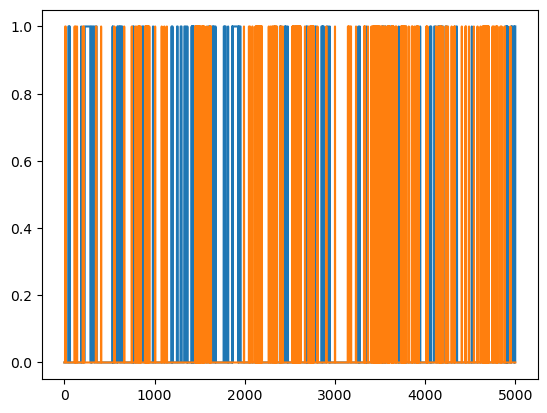

In [40]:
model.evaluate(x_test,y_test)

y_pred = model.predict(x_test)

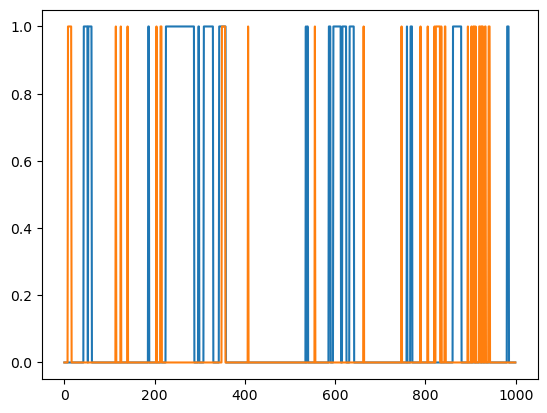

In [43]:
import matplotlib.pyplot as plt
plt.plot(y_test[:,1][0:1000])
pred = np.round(y_pred[:,1][0:1000])
plt.plot(pred)#[5000:10000]

In [72]:
x_win_aug = []
y_win_s2l_aug = []
for i in range(len(y_win_s2l)):
    x_win_aug.append(x_win[i])
    y_win_s2l_aug.append(y_win_s2l[i])
    
    if y_win_s2l[i,1]==1:
        x_win_aug.append(x_win[i])
        y_win_s2l_aug.append(y_win_s2l[i])
x_win_aug = np.asarray(x_win_aug,dtype = int)
y_win_s2l_aug = np.asarray(y_win_s2l_aug,dtype = int)

In [73]:
x_win_aug.shape,y_win_s2l_aug.shape

((72276, 256, 3), (72276, 2))

In [74]:
sum(y_win_s2l_aug[:, 1])/len(y_win_s2l_aug) , sum(y_win_s2l[:, 1])*93213/len(y_win_s2l_aug) , 93213

(0.47321379157673366, 22054.838577121038, 93213)

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x_win_aug, y_win_s2l_aug, test_size=0.30, shuffle = False)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, shuffle = False)
# model = tf.keras.models.load_model('./best.hdf5')
model_aug = Sequential([
    LSTM(100, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = True ),
    Dropout(0.2),
    LSTM(100, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)),
    Dropout(0.2),
    Dense(2, activation = 'softmax') 
])

model_aug.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6, clipvalue=0.5),
                loss='categorical_crossentropy', 
                metrics=['accuracy'],
                )

model_aug.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 256, 100)          41600     
                                                                 
 dropout_20 (Dropout)        (None, 256, 100)          0         
                                                                 
 lstm_21 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 2)                 202       
                                                                 
Total params: 122,202
Trainable params: 122,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_aug.fit(x_train, y_train, batch_size = 256, epochs = 200, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

Epoch 1/200
198/198 [==============================] - 243s 1s/step - loss: 0.7519 - accuracy: 0.5380 - val_loss: 0.7513 - val_accuracy: 0.4752 - lr: 1.0000e-06
Epoch 2/200
198/198 [==============================] - 238s 1s/step - loss: 0.7504 - accuracy: 0.5592 - val_loss: 0.7494 - val_accuracy: 0.5357 - lr: 1.0000e-06
Epoch 3/200
198/198 [==============================] - 240s 1s/step - loss: 0.7488 - accuracy: 0.5733 - val_loss: 0.7475 - val_accuracy: 0.6241 - lr: 1.0000e-06
Epoch 4/200
198/198 [==============================] - 240s 1s/step - loss: 0.7474 - accuracy: 0.5944 - val_loss: 0.7456 - val_accuracy: 0.6728 - lr: 1.0000e-06
Epoch 5/200
198/198 [==============================] - 243s 1s/step - loss: 0.7458 - accuracy: 0.6152 - val_loss: 0.7436 - val_accuracy: 0.6974 - lr: 1.0000e-06
Epoch 6/200
198/198 [==============================] - 242s 1s/step - loss: 0.7441 - accuracy: 0.6332 - val_loss: 0.7416 - val_accuracy: 0.7043 - lr: 1.0000e-06
Epoch 7/200
198/198 [=============

In [63]:
x_win.shape, y_win_s2l.shape

((55175, 256, 3), (55175, 2))

In [65]:
y_win_s2l

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [15]:

x_train, x_test, y_train, y_test = train_test_split(x_win, y_win, test_size=0.20, shuffle = False)
model_s2s = Sequential([
    LSTM(100, return_sequences = True, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3)),
    Dropout(0.2),
    LSTM(100, return_sequences = True, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)),
    Dropout(0.2),
    Dense(2, activation = 'softmax') 
])

model_s2s.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6),#clipvalue=1.0),
                loss='categorical_crossentropy', 
                metrics=['accuracy'],
                )

In [16]:
# y_train = np.asarray(y_train).astype('int').reshape((-1,1))
# y_test = np.asarray(y_test).astype('int').reshape((-1,1))

# model = Sequential([
#     Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(1500,3)),
    
#     Conv1D(filters=64, kernel_size=3, activation='relu'),
#     Dropout(0.5),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
    
#     Dense(1,activation = 'sigmoid')
# ])

# model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = .1),#clipvalue=1.0),
#                 loss='binary_crossentropy', 
#                 metrics=['accuracy'],
#                 )

# history = model.fit(x_train, y_train, batch_size = 1024, epochs = 50, callbacks = [rlr,earlystop,checkpointer,csv_logger])

In [53]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test[:,0], np.round(y_pred[:,0]))

array([[  65, 1281],
       [ 557, 6373]])

In [44]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [45]:
model.save('/model_s2l')

In [46]:
download_file('/model_s2l', 'model_s2l')

/kaggle/working/model_s2l.zip

In [47]:
download_file('/kaggle/working/model_history_log.csv','model_history_log_s2l')

/kaggle/working/model_history_log_s2l.zip

In [ ]:
history_log = pd.read_csv('/kaggle/working/model_history_log.csv')

In [ ]:
history_log['accuracy'].plot()